# Moving Dask XGboost with Fiscal Data, saving and loading Dask XGboost models

This post includes code from [Scalable-Data-Analysis-in-Python-with-Dask](https://github.com/PacktPublishing/-Scalable-Data-Analysis-in-Python-with-Dask/tree/master/Section%202) and [coiled-examples](https://github.com/coiled/coiled-examples).

In [1]:
import numpy as np
import dask.array as da
import pandas as pd
import sqlalchemy as db
from sqlalchemy import create_engine
import sqlite3
import pandas as pd

In [9]:
engine = db.create_engine('sqlite:///fiscal.db')
connection = engine.connect()
metadata = db.MetaData()

In [10]:
engine.execute("SELECT * FROM fiscal_table LIMIT 10").fetchall()

[(1996, 'East China', 'Anhui', 631930, 147002, 2093.3, 50661),
 (1997, 'East China', 'Anhui', 657860, 151981, 2347.32, 43443),
 (1998, 'East China', 'Anhui', 889463, 174930, 2542.96, 27673),
 (1999, 'East China', 'Anhui', 1227364, 285324, 2712.34, 26131),
 (2000, 'East China', 'Anhui', 1499110, 195580, 2902.09, 31847),
 (2001, 'East China', 'Anhui', 2165189, 250898, 3246.71, 33672),
 (2002, 'East China', 'Anhui', 2404936, 434149, 3519.72, 38375),
 (2003, 'East China', 'Anhui', 2815820, 619201, 3923.11, 36720),
 (2004, 'East China', 'Anhui', 3422176, 898441, 4759.3, 54669),
 (2005, 'East China', 'Anhui', 3874846, 898441, 5350.17, 69000)]

In [11]:
sql = """
SELECT year
, region
, province
, gdp
, fdi
, it
, specific
FROM fiscal_table
"""

cnxn = connection

In [12]:
df = pd.read_sql(sql, cnxn)

In [13]:
df

,year,region,province,gdp,fdi,it,specific
0,1996,East China,Anhui,2093.30,50661,631930,147002.0
1,1997,East China,Anhui,2347.32,43443,657860,151981.0
2,1998,East China,Anhui,2542.96,27673,889463,174930.0
3,1999,East China,Anhui,2712.34,26131,1227364,285324.0
4,2000,East China,Anhui,2902.09,31847,1499110,195580.0
...,...,...,...,...,...,...,...
355,2003,East China,Zhejiang,9705.02,498055,2261631,391292.0
356,2004,East China,Zhejiang,11648.70,668128,3162299,656175.0
357,2005,East China,Zhejiang,13417.68,772000,2370200,656175.0
358,2006,East China,Zhejiang,15718.47,888935,2553268,1017303.0


In [14]:
df.columns

Index(['year', 'region', 'province', 'gdp', 'fdi', 'it', 'specific'], dtype='object')

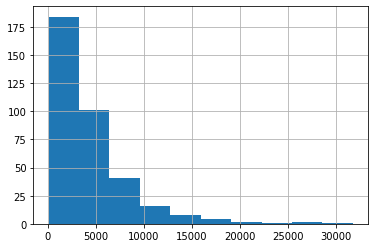

In [15]:
df.gdp.hist()

In [16]:
from dask.distributed import Client

client = Client(processes=False, threads_per_worker=2,
                n_workers=3, memory_limit='4GB')
client

Client Scheduler: inproc://192.168.1.71/13442/1 Dashboard: http://192.168.1.71:8787/status,Cluster Workers: 3 Cores: 6 Memory: 12.00 GB


In [17]:
client.restart()

Client Scheduler: inproc://192.168.1.71/13442/1 Dashboard: http://192.168.1.71:8787/status,Cluster Workers: 3 Cores: 6 Memory: 12.00 GB


In [20]:
from dask import dataframe as dd 

In [21]:
ddf = dd.from_pandas(df, npartitions=5)

In [22]:
print(ddf)

Dask DataFrame Structure:
                year  region province      gdp    fdi     it specific
npartitions=5                                                        
0              int64  object   object  float64  int64  int64  float64
72               ...     ...      ...      ...    ...    ...      ...
...              ...     ...      ...      ...    ...    ...      ...
288              ...     ...      ...      ...    ...    ...      ...
359              ...     ...      ...      ...    ...    ...      ...
Dask Name: from_pandas, 5 tasks


In [23]:
ddf.head()

,year,region,province,gdp,fdi,it,specific
0,1996,East China,Anhui,2093.30,50661,631930,147002.0
1,1997,East China,Anhui,2347.32,43443,657860,151981.0
2,1998,East China,Anhui,2542.96,27673,889463,174930.0
3,1999,East China,Anhui,2712.34,26131,1227364,285324.0
4,2000,East China,Anhui,2902.09,31847,1499110,195580.0


In [24]:
client.id

'Client-e79fe0fe-0d59-11eb-b482-f9dc9eaa58ee'

In [25]:
feat_list = ["year", "fdi"]
cat_feat_list = ["region", "province"]
target = ["gdp"]

In [26]:
ddf["year"] = ddf["year"].astype(int)
ddf["fdi"] = ddf["fdi"].astype(float)
ddf["gdp"] = ddf["gdp"].astype(float)
ddf["it"] = ddf["it"].astype(float)
# ddf["province"] = ddf["province"].astype(float)
# ddf["region"] = ddf["region"].astype(float)

In [27]:
x=ddf[feat_list].persist()
y=ddf[target].persist()

In [28]:
x

,year,fdi
npartitions=5,,
0,int64,float64
72,...,...
...,...,...
288,...,...
359,...,...


In [29]:
y.compute()

,gdp
0,2093.30
1,2347.32
2,2542.96
3,2712.34
4,2902.09
...,...
355,9705.02
356,11648.70
357,13417.68
358,15718.47


In [30]:
print(x.shape,y.shape)

(Delayed('int-97d0cf00-db85-425b-a0d2-08297142db86'), 2) (Delayed('int-01cdae78-a995-48c1-9b93-277a008ad57a'), 1)


In [31]:
x.count().compute()

year    360
fdi     360
dtype: int64

In [32]:
from dask_ml.xgboost import XGBRegressor

In [33]:
XGBR = XGBRegressor()

In [34]:
%%time
XGBR_model = XGBR.fit(x,y)

CPU times: user 54.2 s, sys: 1.02 s, total: 55.2 s
Wall time: 18.4 s


In [35]:
XGBR_model

XGBRegressor()

In [36]:
XGBR_model.save_model('fiscal_model')

In [39]:
XGBR_model.load_model('fiscal_model')

[08:43:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
